In [1]:
import sklearn.metrics 
import numpy as np
from transformers import TextClassificationPipeline, AutoTokenizer, AutoConfig, TrainingArguments, Trainer, AutoModelForSequenceClassification, pipeline
import pandas as pd
import numpy as np
from PIL import Image
# from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn.metrics
import statistics
from collections import Counter
import datasets
import torch
import evaluate
import json
import matplotlib.pyplot as plt
import seaborn as sns


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/mac9908/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda112.so


/home/mac9908/.local/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/home/mac9908/clara/lp_solve_dev'), PosixPath('/home/mac9908/clara/lp_solve_5.5/lpsolve55/bin/ux64')}
  warn(msg)


CUDA SETUP: CUDA runtime path found: /shared/rc/tools/spack-ng-test/opt/spack/linux-rhel7-skylake_avx512/gcc-9.3.0/cuda-11.2.2-77ry53ui4fd6hovqdj6u3fxqwdz276qa/targets/x86_64-linux/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 112
CUDA SETUP: Loading binary /home/mac9908/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda112.so...


/home/mac9908/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA A100-PCIE-40GB with CUDA capability sm_80 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA A100-PCIE-40GB GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
/.autofs/tools/spack/opt/spack/linux-rhel7-skylake_avx512/gcc-9.3.0/python-3.8.7-vbbky6n2roxmrih3hr2ebndq6rmdoymm/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


# Dataset

In [2]:
lib = pd.read_csv('data/liberal.csv')

lib = lib[~lib['expert_label'].isna()]
lib['label'] = lib['label'].map({'asset':0, 'need':1, 'other':2, 'default': 0, 'none': 2})
lib['expert_label'] = lib['expert_label'].map({'asset': 0, 'need':1, 'other':2, 'default': 0, 'none': 2})

In [3]:
con = pd.read_csv('data/conservative.csv')
lib = pd.read_csv('data/liberal.csv')
lib = lib[['comment_id', 'subreddit', 'comment', 'expert_label']]
lib['text'] = lib['comment']
con = con[['comment_id', 'subreddit', 'text', 'expert_label']]
df = pd.concat([lib,con])

In [4]:
df

,comment_id,subreddit,comment,expert_label,text
0,hl4e1z1,nyc,I feel the frequency at which we are seeing fe...,need,I feel the frequency at which we are seeing fe...
1,hl4gpev,nyc,Yes but implying that Chinese people produce f...,other,Yes but implying that Chinese people produce f...
2,hl4qjuw,nyc,there are multiple shrooms-only services aroun...,other,there are multiple shrooms-only services aroun...
3,hl4qz25,nyc,That's literally what I just said... but okay....,other,That's literally what I just said... but okay....
4,hl4t623,nyc,yeah in my experience they'll have 2-3 strains...,other,yeah in my experience they'll have 2-3 strains...
...,...,...,...,...,...
1111,k6gizkb,okc,NaN,other,"Besides the pay, what was actually preventing ..."
1112,je7a7vg,okc,NaN,other,"Well, it’s rush hour in a city in a state that..."
1113,kd0v36v,okc,NaN,other,Your latter point is what I don't think the ma...
1114,gka0m99,okc,NaN,need,But is it really isolated to that area? I hear...


In [5]:
df['label'] = df['expert_label']
df = df[['comment_id', 'subreddit', 'text', 'label']]
df['label'] = df['label'].map({'asset':'asset', 'need':'need', 'other':'other', 'default': 'asset'})
df = df[~df['label'].isna()]
df

/tmp/ipykernel_28637/1742729333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map({'asset':'asset', 'need':'need', 'other':'other', 'default': 'asset'})


,comment_id,subreddit,text,label
0,hl4e1z1,nyc,I feel the frequency at which we are seeing fe...,need
1,hl4gpev,nyc,Yes but implying that Chinese people produce f...,other
2,hl4qjuw,nyc,there are multiple shrooms-only services aroun...,other
3,hl4qz25,nyc,That's literally what I just said... but okay....,other
4,hl4t623,nyc,yeah in my experience they'll have 2-3 strains...,other
...,...,...,...,...
1111,k6gizkb,okc,"Besides the pay, what was actually preventing ...",other
1112,je7a7vg,okc,"Well, it’s rush hour in a city in a state that...",other
1113,kd0v36v,okc,Your latter point is what I don't think the ma...,other
1114,gka0m99,okc,But is it really isolated to that area? I hear...,need


In [6]:
df.groupby('subreddit')['subreddit'].count()

subreddit
Brooklyn            264
ColoradoSprings     400
E8                    1
Queens               46
Rochester           599
VirginiaBeach       200
bronx                33
jacksonville        200
manhattan             4
mesaaz              116
nyc                1449
okc                 200
Name: subreddit, dtype: int64

In [7]:
df

,comment_id,subreddit,text,label
0,hl4e1z1,nyc,I feel the frequency at which we are seeing fe...,need
1,hl4gpev,nyc,Yes but implying that Chinese people produce f...,other
2,hl4qjuw,nyc,there are multiple shrooms-only services aroun...,other
3,hl4qz25,nyc,That's literally what I just said... but okay....,other
4,hl4t623,nyc,yeah in my experience they'll have 2-3 strains...,other
...,...,...,...,...
1111,k6gizkb,okc,"Besides the pay, what was actually preventing ...",other
1112,je7a7vg,okc,"Well, it’s rush hour in a city in a state that...",other
1113,kd0v36v,okc,Your latter point is what I don't think the ma...,other
1114,gka0m99,okc,But is it really isolated to that area? I hear...,need


In [11]:
df_final = df.drop(columns=['text'])

In [12]:
df_final.to_json('community_needs.jsonl', orient='records', lines=True)

# RQ1a - Classification of Needs and Assets

In [17]:
class CommunityNeedsAssetsClassifier:
    def __init__(self, case='need'):
        self.case = case
        if case == 'sentiment':
            self.labels = ['positive', 'negative', 'neutral']
            self.MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
        else:
            self.labels = ['asset', 'need', 'other']
            self.MODEL = f"bert-base-cased"
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        self.metric = evaluate.load("f1")
        self.cf_metric = evaluate.load("BucketHeadP65/confusion_matrix")
        self.classification_report_metric = evaluate.load("bstrai/classification_report")
        self.split = 0.2
        self.seed = 42
        pass
    def labelify_sentiment(self, examples):
        label_encode = {
            'asset': 'Positive',
            'need': 'Negative',
            'none': 'Neutral',
            'other': 'Neutral',
        }
        sent_encode = {
            'Positive': 0,
            'Negative': 1,
            'Neutral': 2,
        }
        examples['label'] = label_encode[examples['label']]
        examples['label'] = sent_encode[examples['label']]
        return examples
    def labelify_need(self, examples):
        label_encode = {
            'asset': 0,
            'need': 1,
            'none': 2,
            'other': 2
        }
        examples['label'] = label_encode[examples['label']]
        return examples
    def read_and_split(self, df, config='standard'):
        if config=='standard':
            dt = datasets.Dataset.from_pandas(df)
            dt = dt.train_test_split(test_size=self.split)
            small_train=dt['train'].shuffle(seed=self.seed)
            small_test=dt['test'].shuffle(seed=self.seed)
        elif config=='liberal':
            df_train = df[df['subreddit'].isin(['Brooklyn','Queens','Rochester','bronx','manhattan','nyc'])]
            df_test = df[~df['subreddit'].isin(['Brooklyn','Queens','Rochester','bronx','manhattan','nyc'])]
            small_train = df_train.sample(frac=1)
            small_train = datasets.Dataset.from_pandas(small_train)
            small_test = df_test.sample(frac=1)
            small_test = datasets.Dataset.from_pandas(small_test)
        elif config=='conservative':
            df_train = df[df['subreddit'].isin(['ColoradoSprings', 'VirginiaBeach', 'jacksonville', 'mesaaz', 'okc'])]
            df_test = df[~df['subreddit'].isin(['ColoradoSprings', 'VirginiaBeach', 'jacksonville', 'mesaaz', 'okc'])]
            small_train = df_train.sample(frac=1)
            small_train = datasets.Dataset.from_pandas(small_train)
            small_test = df_test.sample(frac=1)
            small_test = datasets.Dataset.from_pandas(small_test)
        if self.case == 'need':
            small_train = small_train.map(self.labelify_need)
            small_test = small_test.map(self.labelify_need)
        elif self.case=='sentiment':
            small_train = small_train.map(self.labelify_sentiment)
            small_test = small_test.map(self.labelify_sentiment)
        return small_train, small_test
    def tokenize_function(self, examples):
        return self.tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    def report(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return self.classification_report_metric.compute(predictions=predictions, references=labels)
    def conf_matrix_calc(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return self.cf_metric.compute(predictions=predictions, references=labels)
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return self.metric.compute(predictions=predictions, references=labels, average="weighted")

In [138]:
def train(df, case='need',config='standard', batch_size=32, epochs=10):
    cna = CommunityNeedsAssetsClassifier(case=case)
    train, test = cna.read_and_split(df=df, config=config)
    print(train)
    print(test)
    train = train.map(cna.tokenize_function, batched=True)
    test = test.map(cna.tokenize_function, batched=True)
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", 
                                                            num_labels=3, 
                                                            id2label={
                                                                0: "asset",
                                                                1: "need",
                                                                2: "other"
                                                            },
                                                            label2id={
                                                                "asset": 0,
                                                                "need": 1,
                                                                "other": 2
                                                            })
    training_args = TrainingArguments(
        output_dir=f"{case}_classification_checkpoints", 
        evaluation_strategy="epoch", 
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=test,
        compute_metrics=cna.compute_metrics,
    )
    trainer.train()
    trainer.save_model(f'{case}_{config}_classification')
    
def eval(df, case='need', config='standard', batch_size=32):      
    cna = CommunityNeedsAssetsClassifier(case=case)
    train, test = cna.read_and_split(df=df, config=config)
    train = train.map(cna.tokenize_function, batched=True)
    test = test.map(cna.tokenize_function, batched=True)
    if case=='need':
        model = AutoModelForSequenceClassification.from_pretrained(f'{case}_{config}_classification')
        training_args = TrainingArguments(output_dir=f"{case}_classification_checkpoints", 
                            evaluation_strategy="epoch", 
                            save_strategy="epoch",
                            per_device_train_batch_size=batch_size,
                            per_device_eval_batch_size=batch_size)
        trainer = Trainer(
            model=model,
            args=training_args,
            compute_metrics=cna.conf_matrix_calc
        )
        result = trainer.evaluate(eval_dataset=test)
        with open(f'conf_matrix_{case}_{config}.json', 'w') as f:
            f.write(json.dumps(
                {
                    'loss': result['eval_loss'],
                    'confusion_matrix': result['eval_confusion_matrix'].tolist()
                }
            ))

        visualize(result['eval_confusion_matrix'], config=config, case=case)
        trainer = Trainer(
            model=model,
            args=training_args,
            compute_metrics=cna.report
        )
        result = trainer.evaluate(eval_dataset=test)
        print(result)
        with open(f'{case}_{config}_classification_report.json', 'w') as f:
            f.write(json.dumps(result))
    elif case=='sentiment':
        senti = pipeline("sentiment-analysis", model=cna.MODEL, tokenizer=cna.tokenizer, device=0)
        res = senti(df['text'].tolist(), padding=True,truncation=True,max_length=512)
        predict = [p['label'] for p in res]
        df['predict'] = predict
        df['predict'] = df['predict'].map({'positive':'asset', 'negative': 'need', 'neutral': 'other'})
        display(sklearn.metrics.classification_report(y_pred=df['predict'], y_true=df['label'], output_dict=True))
        cm = sklearn.metrics.confusion_matrix(y_pred=df['predict'], y_true=df['label'], labels=["asset", "need", "other"])
        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        return df
        
def visualize(conf_matrix, config='standard', case='need'):
    plt.figure(figsize=(8,6), dpi=100)
    sns.set(font_scale = 1.1)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    if case == 'need' or case=='llm':
        ax.set_xlabel('Predicted', fontsize=14)
        ax.xaxis.set_ticklabels([
            'asset',
            'need',
            'other'
        ])
        ax.set_ylabel('Observed', fontsize=14)
        ax.yaxis.set_ticklabels([
            'asset',
            'need',
            'other'
        ])
    elif case == 'sentiment':
        ax.set_xlabel('Predicted', fontsize=14)
        ax.xaxis.set_ticklabels([
            'Positive',
            'Negative',
            'Neutral'
        ])
        ax.set_ylabel('Observed', fontsize=14)
        ax.yaxis.set_ticklabels([
            'asset',
            'need',
            'other'
        ])
    ax.set_title('', fontsize=18)
    plt.savefig(f'Confusion Matrix for {case}_{config}')
    plt.show()

## Classification Results

### Supervised Classification

In [13]:
train(df)

Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mac9908 (urban-data-science). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1
1,No log,0.627564,0.716695
2,No log,0.653849,0.719387
3,No log,0.817749,0.735081
4,No log,1.025806,0.746230
5,No log,1.352828,0.723181
6,0.292100,1.545347,0.719717
7,0.292100,1.637131,0.743237
8,0.292100,1.628030,0.729257
9,0.292100,1.648588,0.738917
10,0.292100,1.691504,0.738882


Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

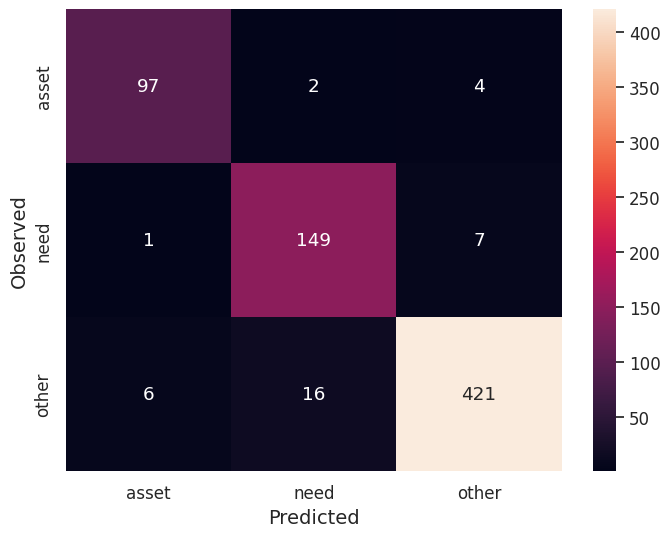

{'eval_loss': 0.3695984184741974, 'eval_0': {'precision': 0.9326923076923077, 'recall': 0.941747572815534, 'f1-score': 0.9371980676328503, 'support': 103}, 'eval_1': {'precision': 0.8922155688622755, 'recall': 0.9490445859872612, 'f1-score': 0.9197530864197532, 'support': 157}, 'eval_2': {'precision': 0.9745370370370371, 'recall': 0.9503386004514672, 'f1-score': 0.9622857142857143, 'support': 443}, 'eval_accuracy': 0.9487908961593172, 'eval_macro avg': {'precision': 0.9331483045305401, 'recall': 0.9470435864180874, 'f1-score': 0.9397456227794393, 'support': 703}, 'eval_weighted avg': {'precision': 0.9500214216374002, 'recall': 0.9487908961593172, 'f1-score': 0.9491112474575479, 'support': 703}, 'eval_runtime': 5.7345, 'eval_samples_per_second': 122.591, 'eval_steps_per_second': 3.836}


In [24]:
eval(df)

### Sentiment Classification

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'asset': {'precision': 0.4440894568690096,
  'recall': 0.5840336134453782,
  'f1-score': 0.5045372050816697,
  'support': 476},
 'need': {'precision': 0.35159235668789807,
  'recall': 0.6579261025029798,
  'f1-score': 0.4582814445828144,
  'support': 839},
 'other': {'precision': 0.675531914893617,
  'recall': 0.404642694583523,
  'f1-score': 0.5061201252490749,
  'support': 2197},
 'accuracy': 0.48946469248291574,
 'macro avg': {'precision': 0.4904045761501749,
  'recall': 0.5488674701772936,
  'f1-score': 0.48964625830451963,
  'support': 3512},
 'weighted avg': {'precision': 0.5667756793143712,
  'recall': 0.48946469248291574,
  'f1-score': 0.49447715170731027,
  'support': 3512}}

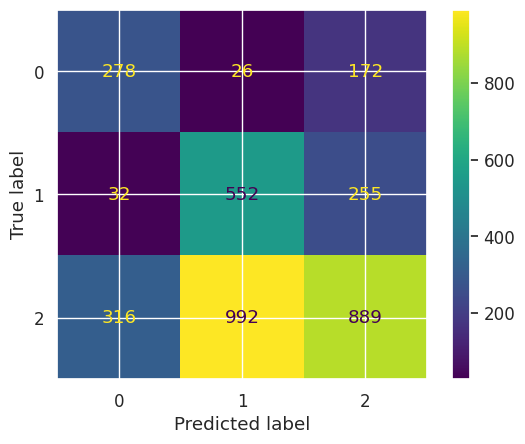

In [177]:
senti = eval(df, case='sentiment')

### LLM Classification

In [133]:
import json
import pandas as pd
from os.path import join as pjoin
import datasets
import re
import time
from tqdm import tqdm
import google.generativeai as palm
import openai
import tiktoken
import os
import math
import sys
from dotenv import load_dotenv
import argparse
import logging

class ZeroShotLLM:
    def __init__(self,df,folder,file, llm='palm', censor=False, task='need0') -> None:
        self.llm = llm
        if llm == 'palm':
            self.llm_model = 'models/text-bison-001'
        elif llm == 'bard':
            self.llm_model = 'models/chat-bison-001'
        elif llm == 'gemini':
            self.llm_model = 'models/gemini-pro'
        elif llm == 'chatgpt':
            self.encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
        self.task = task
        self.filename = file
        self.folder = folder
        self.censor = 'censored' if censor else 'uncensored'
        self.prompt=""
        datasets.logging.set_verbosity(datasets.logging.ERROR)
        load_dotenv(dotenv_path='secrets.env')
        palm.configure(api_key='INSERT_KEY')
        self.dataset = datasets.Dataset.from_pandas(df)
        
    def need_prompt(self, text):
        result_format = '{"answer": ""}'
        return f"""
        {text}
        \n\n
        According to the given text, which of the following is this comment talking about?
        1. Need: A community issue, problem, or need (Something negative the community concerned with. Or something the community is missing) 
        2. Asset: A community highlight, strength or asset (Something positive the community has)
        3. Other: Other (If unsure write what it is about)
        4. None: None of the above (the comment is about something else and has nothing to do with the community)
        Answer in JSON in the following format:
        {result_format}
        """,128
    def need_fewshot_prompt(self, text):
        result_format = '{"answer": ""}'
        examples = """
        
        """
        return f"""
        {text}
        \n\n
        According to the given text, which of the following is this comment talking about?
        1. Need: A community issue, problem, or need (Something negative the community concerned with. Or something the community is missing) 
        2. Asset: A community highlight, strength or asset (Something positive the community has)
        3. Other: Other (If unsure write what it is about)
        4. None: None of the above (the comment is about something else and has nothing to do with the community)
        Examples:
        {examples}
        Answer in JSON in the following format:
        {result_format}
        """,128
    def label(self, start=0, end=100, step=10):
        datasets.logging.disable_progress_bar()
        for i in tqdm(range(start,end,step), desc="label"):
            labeler = getattr(self, self.llm)
            dt = self.dataset.select(range(i, i+step)).map(lambda x: labeler(x))
            dt.to_json(pjoin(self.folder, 
                             f'{self.llm}_{self.task}_labeled_{i}_{self.filename}.jsonl'
                        ))
            time.sleep(60)
        datasets.logging.enable_progress_bar()

    def create_prompt(self, text=""):
        fnc = getattr(self, f'{self.task}_prompt')
        return fnc(text)
    def jsonify(self, x):
        jsonify = getattr(self, f"{self.llm}_{self.task}_jsonify")
        return jsonify(x)
    
    def parse(self):
        folder = self.folder
        d = datasets.load_dataset(
            pjoin(folder, f'{self.llm}'), 
            data_files=f"{self.llm}_{self.task}_labeled.jsonl", 
            split="train")
        d = d.map(self.jsonify)
        d.to_json(pjoin(folder,self.llm, f"{self.llm}_{self.task}_parsed.jsonl"))
        print(d)
        d.cleanup_cache_files()

    def combine(self):
        datasets.logging.disable_progress_bar()
        raw_folder = self.folder
        dt = []
        for file in tqdm(os.listdir(raw_folder), desc="Combine"):
            d = datasets.load_dataset(
                raw_folder, 
                data_files=file, 
                split="train"
            )
            d.cleanup_cache_files()
            dt.append(d)
        res = datasets.concatenate_datasets(dt)
        res.to_json(pjoin(self.folder, self.llm, f'{self.llm}_{self.task}_labeled.jsonl'))
        datasets.logging.enable_progress_bar()

    def palm(self, example):
        model = self.llm_model
        text = f"{example['text']}"
        try:
            prompt, max_tokens = self.create_prompt(text)
            answer = palm.generate_text(
                model=model,
                prompt=f"{prompt}",
                temperature=0,
                safety_settings=[
                    {
                        'category':c, 
                        'threshold': palm.types.HarmBlockThreshold.BLOCK_NONE
                    } for c in palm.types.HarmCategory
                ],
                max_output_tokens=max_tokens
            )
            example['candidates'] = answer.candidates
            return example
        except Exception as e:
            print(e)
    def gemini(self, example):
        model = self.llm_model
        text = f"{example['text']}"
        try:
            prompt, max_tokens = self.create_prompt(text)
            answer = palm.generate_text(
                model=model,
                prompt=f"{prompt}",
                temperature=0,
                safety_settings=[
                    {
                        'category':c, 
                        'threshold': palm.types.HarmBlockThreshold.BLOCK_NONE
                    } for c in palm.types.HarmCategory
                ],
                max_output_tokens=max_tokens
            )
            example['candidates'] = answer.candidates
            return example
        except Exception as e:
            print(e)
    def palm_need_extract(self, text):
        objs = re.findall(r'\{[\w\d\s\n,:"\[\]\r]*\}',text)
        print(objs)
        return objs
    
    def palm_need_jsonify(self, x):
            candidates = x["candidates"]
            safety_ratings = []
            labels = []
            for c in candidates:
                output = c["output"]
                safety_ratings += c["safety_ratings"]
                output = output.replace("```","")
                try:
                    labels.append(json.loads(output)['answer'])
                except Exception as e:
                    label = self.palm_need_extract(output)
                    if len(label) >= 1:
                        labels.append(label[0])
                    elif len(label) == 0:
                        # If nothing is assigned then it's N/A
                        label = ['Other']
                    else:
                        print(output)
                        raise e
                    pass   
            try:
                x['label_palm'] = labels[0]
            except:
                print(labels)
                x['label_palm'] = 'Other'
            x['safety_ratings'] = safety_ratings
            return x

In [124]:
labeler = ZeroShotLLM(
    folder='palm_label',
    df=df,
    file='palm_label',
    llm='palm'
)
# labeler.label(start=0, end=3520, step=30)

In [103]:
labeler.combine()

Combine: 100%|██████████| 117/117 [00:13<00:00,  8.41it/s]


In [125]:
labeler.parse()

[]
[]
[]
[]
Dataset({
    features: ['comment_id', 'subreddit', 'text', 'label', 'predict', '__index_level_0__', 'candidates', 'label_palm', 'safety_ratings'],
    num_rows: 3510
})


In [126]:
d = pd.read_json('data/palm_need_parsed.jsonl', orient='records', lines=True)

In [129]:
d['label_palm'] = d['label_palm'].str.lower()
d['label_palm'] = d['label_palm'].map({'asset': 'asset', 'need':'need', 'other':'other', 'none':'other'})
d.groupby('label_palm')['label_palm'].count()

label_palm
asset     903
need     1083
other    1524
Name: label_palm, dtype: int64

In [130]:
d.groupby('label')['label'].count()

label
asset     476
need      838
other    2196
Name: label, dtype: int64

{'asset': {'precision': 0.4418604651162791,
  'recall': 0.8382352941176471,
  'f1-score': 0.5786802030456852,
  'support': 476},
 'need': {'precision': 0.5152354570637119,
  'recall': 0.665871121718377,
  'f1-score': 0.5809474232170745,
  'support': 838},
 'other': {'precision': 0.8156167979002624,
  'recall': 0.5660291438979964,
  'f1-score': 0.6682795698924732,
  'support': 2196},
 'accuracy': 0.6267806267806267,
 'macro avg': {'precision': 0.5909042400267511,
  'recall': 0.6900451865780068,
  'f1-score': 0.6093023987184111,
  'support': 3510},
 'weighted avg': {'precision': 0.6932157785195772,
  'recall': 0.6267806267806267,
  'f1-score': 0.6352785335582695,
  'support': 3510}}

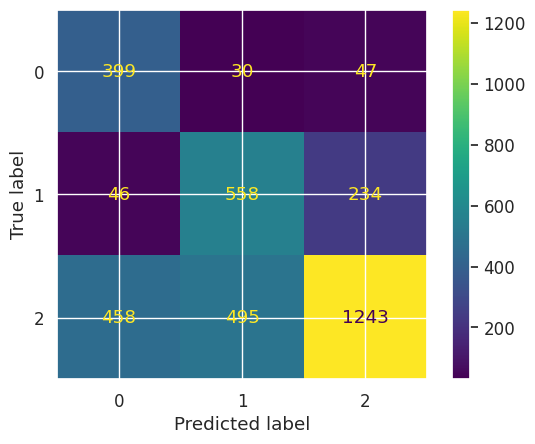

In [132]:
display(sklearn.metrics.classification_report(y_pred=d['label_palm'], y_true=d['label'], output_dict=True))
cm = sklearn.metrics.confusion_matrix(y_pred=d['label_palm'], y_true=d['label'], labels=["asset", "need", "other"])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## In The Wild

In [40]:
itw = pd.read_json('data/reddit_itw.jsonl', orient='records', lines=True)
itw = datasets.Dataset.from_pandas(itw)
itw

Dataset({
    features: ['submission_id', 'comment_id', 'subreddit', 'title', 'text', 'search_term', 'topic'],
    num_rows: 23938
})

In [42]:
def predict(data, case='need', batch_size=32):
    model = AutoModelForSequenceClassification.from_pretrained(f'{case}_classification')
    tokenizer = AutoTokenizer.from_pretrained(f"bert-base-cased")
    cna = CommunityNeedsAssetsClassifier()
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    test = data.map(tokenize_function, batched=True)
    training_args = TrainingArguments(output_dir=f"{case}_classification_checkpoints", 
                                evaluation_strategy="epoch", 
                                save_strategy="epoch",
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size)
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=cna.conf_matrix_calc
    )
    result = trainer.predict(test_dataset=test)
    df = data.to_pandas()
    df['label'] = np.argmax(result.predictions, axis=-1)
    return df

In [43]:
res = predict(itw)

Map:   0%|          | 0/23938 [00:00<?, ? examples/s]

In [44]:
res.groupby('label')['label'].count()

label
0     1565
1     1525
2    20848
Name: label, dtype: int64

In [46]:
res[res['label']==0]['text'].iloc[250]

"Not sure about any of those apartments, but the Regency seems pretty nice from what I've seen/heard of it. There are a few duplexes/fourplexes in the Uptown area that I've seen up for rent too.\n\nThe transit system is definitely a lot better than people give it credit for; it covers a veer wide range of areaand includes routes that go to Edmond and Norman, but it doesn't run on Sundays (the Edmond bus doesn't run on Saturdays either). There are also bikes that you can rent throughout the downtown area from a rack and replace at any of the racks in the area.\n\nSide note; I'm a barber-stylist who works in Uptown. PM if you're in need once you get here, and I hope it all works out well for you. OKC can be a very fun and cool place if you seek out and find businesses/friends/areas that suit your interests!"

In [31]:
def build_sample(data, label=0):
    data = data[data['label']==label]
    cs = data[data['subreddit']=='ColoradoSprings'].sample(200)
    vb = data[data['subreddit']=='VirginiaBeach'].sample(100)
    jv = data[data['subreddit']=='jacksonville'].sample(100)
    mz = data[data['subreddit']=='mesaaz']
    okc = data[data['subreddit']=='okc'].sample(100)
    cat = pd.concat([cs,vb,jv,mz,okc])
    return cat
    
# asset = res[res['label']==0]
# need = res[res['label']==1]
asset = build_sample(res)
need = build_sample(res, label=1)
conservative = pd.concat([asset, need])
conservative['label'] = conservative['label'].map({0: "asset",1: "need",2: "other"})
conservative

,submission_id,comment_id,subreddit,title,text,search_term,topic,label
14236,ztsqa1,j1gwzyr,ColoradoSprings,which area should i avoid?,"Hey! I’ll get right into it here, one of the p...",community needs,default,asset
16708,surh4y,hxdp97d,ColoradoSprings,Deaf Community,Try the Deaf Colorado Springs Facebook page. M...,community school,default,asset
12454,17quirb,k8ev435,ColoradoSprings,Disappointed in election results,There are a lot of “but muh taxes” types in D2...,community,default,asset
9265,uu5pfk,i9de3yv,ColoradoSprings,"Peace out, Colorado Springs!","LOLZ Drive north on Union or east on Woodmen,...",programs services household receive,entities,asset
16621,w7sog2,iht42ni,ColoradoSprings,Any In-Person Spanish Classes Available in the...,They currently offer a bachelor's in nursing.,community school,default,asset
...,...,...,...,...,...,...,...,...
4347,17gaxij,k6gizkb,okc,Are Oklahoma schools really that bad? And by w...,"Besides the pay, what was actually preventing ...",community,default,need
5397,1262uo9,je7a7vg,okc,Y'all need to learn how to drive,"Well, it’s rush hour in a city in a state that...",community,default,need
7636,18gcixv,kd0v36v,okc,I have the facts and I'm voting YES,Your latter point is what I don't think the ma...,welfare,default,need
5701,l2zr7v,gka0m99,okc,"Buying a house in the ""wheeler district"" (the ...",But is it really isolated to that area? I hear...,community,default,need


In [52]:
a = res[res['label']==0].sample(50, random_state=42)
b = res[res['label']==1].sample(50, random_state=42)
c = res[res['label']==2].sample(100, random_state=42)
d = pd.concat([a,b,c])
d

,submission_id,comment_id,subreddit,title,text,search_term,topic,label
7846,r3h05q,hmbspmb,okc,Anyone involved with any animal rescues? There...,Try Hands Helping Paws for TNR and the shelter...,welfare,default,0
3644,17i3c12,k6uaz6b,okc,Mountain biking community here in okc?,I've been mtb around okc for a year now and I ...,community,default,0
22080,wg3r92,iiykl59,jacksonville,Local Politics Race Primer: Upcoming Sheriff Race,">Clark has ran a very strong, active, ground c...",community needs,default,0
20093,wnwe3n,ikba3xh,jacksonville,Considering buying home in Winchester Ridge ar...,Have you thought about Middleburg close to the...,community,default,0
927,13yetqy,jmp6iyn,VirginiaBeach,Finding Asian Communities / how to make friend...,I would also recommend “north end running club...,community,default,0
...,...,...,...,...,...,...,...,...
2750,15godfj,jurmwzf,okc,Churches?,Hmm... They look similar to the church we went...,programs services household receive,entities,2
9584,uu5pfk,i9h3gtu,ColoradoSprings,"Peace out, Colorado Springs!","Ugh, spiders?! LOLZ\n\nSeriously, though, I t...",programs services household receive,entities,2
4310,17gaxij,k6fiup6,okc,Are Oklahoma schools really that bad? And by w...,I went to a poor school. We didn't have other...,community,default,2
7874,73hpkr,dnrp2sg,okc,Oklahoma City is near the top of the affordabi...,FY18 we have budgeted 800B for defense and 400...,welfare,default,2


In [54]:
d = d.sample(frac=1)
d.to_csv('in_the_wild_verification.csv')

In [56]:
d = pd.read_csv('data/itw_verification_labeled.csv')
d

,Unnamed: 0,submission_id,comment_id,subreddit,title,text,search_term,topic,label,expert_label
0,541,wxcvwe,iltkb2r,VirginiaBeach,ABC true crime show to air story on Virginia B...,u/shotyoungman?,programs services household receive,entities,2,2
1,14739,zgb0gl,izfzlgu,ColoradoSprings,10 weekend things to do in and around Colorado...,There is also a Bill Burr comedy show at Broad...,community needs,default,0,0
2,9920,11nuemf,jbrpllg,ColoradoSprings,Buyer Beware - Very Kind Jewelry & Piercing,The prices are not displayed anywhere. The cle...,programs services household receive,entities,2,2
3,13617,zfh58y,izel9et,ColoradoSprings,D20 School Board talking about segregated schools,Gregory's retirement or the segregated school?...,community needs,default,2,2
4,22658,18763kz,kbq4956,jacksonville,The Jags leaving would possibly transform the ...,"Ah yes the point of government, to get itself ...",welfare,default,2,2
...,...,...,...,...,...,...,...,...,...,...
195,10385,acuhpw,edtirul,ColoradoSprings,Pet Cremains & Local Pet Crematoriums (disturb...,"Yeah, I can't imagine that it was soley my cat...",programs services household receive,entities,2,2
196,14188,ln7aq1,go70vsf,ColoradoSprings,For EVERY local complaining about Colorado Spr...,I was unable to attend but I did respond to th...,community needs,default,2,2
197,18560,17k2axi,k756or3,jacksonville,A warning regarding Eddison at Deerwood LC and...,Definitely update,programs services household receive,entities,2,2
198,9717,uu5pfk,i9fhysr,ColoradoSprings,"Peace out, Colorado Springs!","> No, just burned down cities in 2020\n\nWhich...",programs services household receive,entities,2,1


In [58]:
sklearn.metrics.classification_report(y_pred=d['label'], y_true=d['expert_label'], output_dict=True)

{'0': {'precision': 0.9,
  'recall': 0.9183673469387755,
  'f1-score': 0.9090909090909091,
  'support': 49},
 '1': {'precision': 0.82,
  'recall': 0.9534883720930233,
  'f1-score': 0.8817204301075269,
  'support': 43},
 '2': {'precision': 0.94,
  'recall': 0.8703703703703703,
  'f1-score': 0.9038461538461539,
  'support': 108},
 'accuracy': 0.9,
 'macro avg': {'precision': 0.8866666666666667,
  'recall': 0.9140753631340565,
  'f1-score': 0.8982191643481966,
  'support': 200},
 'weighted avg': {'precision': 0.9044,
  'recall': 0.9,
  'f1-score': 0.9003740882773141,
  'support': 200}}

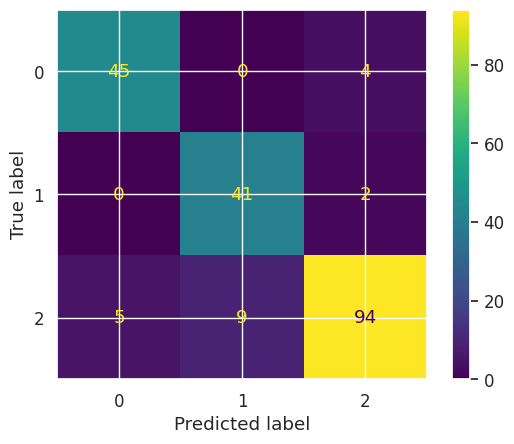

In [65]:
cm = sklearn.metrics.confusion_matrix(y_pred=d['label'], y_true=d['expert_label'], labels=None)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [135]:
import spacy
nlp = spacy.load("en_core_web_sm")

## Asset Significance Test

In [79]:
# calculate number of entities
def ner_mask(x):
    doc = nlp(x['text'])
    res = []
    lbl = []
    e_labels = ['ORG', 'NORP', 'GPE', 'PERSON', 'WORK_OF_ART']
    for e in reversed(doc.ents): #reversed to not modify the offsets of other entities when substituting
        if e.label_ in e_labels:
            res.append(e.text)
            lbl.append(e.label_)
    x['num_entities'] = len(res)
    return x
# ner_mask(df.iloc[500])
dt = datasets.Dataset.from_pandas(df)
dt1 = dt.map(ner_mask)
df1 = dt1.to_pandas()


Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [82]:
df1.groupby('label')['num_entities'].mean()

label
asset    2.855042
need     2.240763
other    1.873464
Name: num_entities, dtype: float64

In [81]:
df1['num_entities'].mean()

2.094248291571754

In [73]:
from scipy.stats import normaltest, f_oneway

In [59]:
stat, p = normaltest(df1['num_entities'])

In [83]:
stat, p = f_oneway(df1[df1['label']=='asset']['num_entities'], df1[df1['label']!='asset']['num_entities'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Cant Reject H0: Mean_num_assets=Mean_num_others')
else:
	print('Reject H0: Mean_num_assets=Mean_num_others')

stat=7.683, p=0.006
Reject H0: Mean_num_assets=Mean_num_others


## Need Significance Test

In [208]:
def contingency_table(data, case='need'):
    data = data.copy()
    if case=='need':
        ml = {'asset': 'other', 'need':'need', 'other': 'other'}
        mp = {'asset': 'other', 'need':'negative', 'other': 'other'}
    elif case=='asset':
        ml = {'asset': 'asset', 'need':'other', 'other': 'other'}
        mp = {'asset': 'positive', 'need':'other', 'other': 'other'}
    else:
        ml = {'asset':'asset', 'need':'need', 'other':'other'}
        mp = {'asset':'positive', 'need':'negative', 'other':'neutral'}
    data['predict'] = data['predict'].map(mp)
    data['label'] = data['label'].map(ml)
    display(data.groupby(['label', 'predict'])['predict'].count().unstack())
    return data.groupby(['label', 'predict'])['predict'].count().unstack().to_numpy()

In [209]:
import numpy as np
from scipy.stats import chi2_contingency
def hypothesis_test(data, case=['need', 'negative']):
    # Create the observed contingency table
    print("Observed Counts:")
    contingency = contingency_table(data.copy(), case=case[0])
    '''
    1:
    label | predict | Count
    ------+---------+-------
    asset | negative | 26
    asset | other    | 450
    need  | negative | 552
    need  | other    | 287
    other | negative | 992
    other | other    | 1205
    2:
    label | predict | Count
    ------+---------+-------
    need  | negative | 552
    need  | other    | 287
    other | negative | 1018
    other | other    | 1655
    '''

    print(f'Null Hypothesis (H0): The variables {case[0]} and {case[1]} are independent.')
    print(f'Alternative Hypothesis (H1): There is a significant association between {case[0]} and {case[1]}.')

    # Step 3: Create a Contingency Table
    observed_counts = contingency

    # Step 4: Calculate Expected Counts
    chi2, p, dof, expected = chi2_contingency(observed_counts)

    # Step 5: Compute Chi-Square Statistic
    print("Chi-Square Statistic:", chi2)

    # Step 6: Determine Degrees of Freedom
    print("Degrees of Freedom:", dof)

    # Step 7: Compare with Critical Value or P-Value
    print("P-Value:", p)
    
    print("Expected:", expected)

    # Step 8: Make a Decision
    alpha = 0.05
    if p < alpha:
        print(f"Reject the null hypothesis. There may be significant association between {case[0]} and {case[1]}.")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant association between {case[0]} and {case[1]}.")

In [210]:
hypothesis_test(senti, case=['need', 'negative'])

Observed Counts:


predict,negative,other
label,,
need,552,287
other,1018,1655


Null Hypothesis (H0): The variables need and negative are independent.
Alternative Hypothesis (H1): There is a significant association between need and negative.
Chi-Square Statistic: 197.20630534515178
Degrees of Freedom: 1
P-Value: 8.501578487769044e-45
Expected: [[ 375.06548975  463.93451025]
 [1194.93451025 1478.06548975]]
Reject the null hypothesis. There may be significant association between need and negative.


In [215]:
hypothesis_test(senti, case=['asset', 'positive'])

Observed Counts:


predict,other,positive
label,,
asset,198,278
other,2688,348


Null Hypothesis (H0): The variables asset and positive are independent.
Alternative Hypothesis (H1): There is a significant association between asset and positive.
Chi-Square Statistic: 615.8064724191884
Degrees of Freedom: 1
P-Value: 6.107157020403415e-136
Expected: [[ 391.15489749   84.84510251]
 [2494.84510251  541.15489749]]
Reject the null hypothesis. There may be significant association between asset and positive.


In [214]:
hypothesis_test(senti, case=['conversation type', 'sentiment'])

Observed Counts:


predict,negative,neutral,positive
label,,,
asset,26,172,278
need,552,255,32
other,992,889,316


Null Hypothesis (H0): The variables conversation type and sentiment are independent.
Alternative Hypothesis (H1): There is a significant association between conversation type and sentiment.
Chi-Square Statistic: 810.9513588535095
Degrees of Freedom: 4
P-Value: 3.2597511307334003e-174
Expected: [[212.7904328  178.36446469  84.84510251]
 [375.06548975 314.38610478 149.54840547]
 [982.14407745 823.24943052 391.60649203]]
Reject the null hypothesis. There may be significant association between conversation type and sentiment.
